In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm
import hiplot as hip
from copy import deepcopy
import datetime

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset, TensorDataset

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelper import *
# from deepadr.model_gnn import GCN as testGCN
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
# from deepadr.model_attn_siamese import *
from ogb.graphproppred import Evaluator
os.chdir(cwd)

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI

In [8]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [9]:
# report_available_cuda_devices()

In [10]:
n_gpu = torch.cuda.device_count()
n_gpu

1

In [11]:
device_cpu = get_device(to_gpu=False)
# device_gpu = get_device(True, index=0)

# fdtype = torch.float32

In [12]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print(sys.version)

torch: 1.9.1
CUDA: 11.1
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]


In [13]:
# print(torch.cuda.memory_summary(device=device_gpu))

### Preparing dataset 

In [14]:
score = 'total_thresh'
score_val = 4

In [15]:
# TDC Tox
# DSdataset_name = 'SynergxZloewe' #'OncoPolyPharmacology' #'DrugComb'
DSdataset_name = f'DrugComb_{score}_{score_val}' #'DrugComb'


#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [16]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
targetdata_dir_exp = create_directory(os.path.join(targetdata_dir, "experiments"))
# # ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))
print(targetdata_dir)

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
/cluster/home/skyriakos/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v1


In [17]:
# %%time

# # Make sure to first run the "data_generation" notebook first

# dataset = MoleculeDataset(root=targetdata_dir)

In [18]:
# dataset.data.y

In [19]:
# fold_partitions = get_stratified_partitions(dataset.data.y,
#                                             num_folds=5,
#                                             valid_set_portion=0.1,
#                                             random_state=42)

In [20]:
# print("Number of training graphs: "+ str(len(fold_partitions[0]['train'])))
# print("Number of validation graphs: "+ str(len(fold_partitions[0]['validation'])))
# print("Number of testing graphs: "+ str(len(fold_partitions[0]['test'])))


### Hyper Parameters

In [21]:
time_stamp = "2022-02-28_18-30-08"

import glob
exp_dirs = glob.glob(targetdata_dir_exp+"/fold_*_"+time_stamp)
len(exp_dirs)

5

In [22]:
folds = []

for edir in exp_dirs:
    fold = edir.split("/")[-1].split('_')[1]
    df_curves = pd.read_csv(edir + "/curves.csv")
#     le = df_curves.tail(1)
#     folds.append([fold, le.test_aupr.values[0], le.test_auc.values[0]])
    df_curves["fold"] = [fold] * len(df_curves)
    folds.append(df_curves)

In [23]:
df_folds = pd.concat(folds)
df_folds

,epoch,train_aupr,valid_aupr,test_aupr,train_auc,valid_auc,test_auc,fold
0,0,0.601468,0.596462,0.592130,0.687900,0.672972,0.679821,0
1,1,0.704614,0.696630,0.695167,0.764367,0.754021,0.762025,0
2,2,0.740340,0.729158,0.729074,0.793660,0.785882,0.791133,0
3,3,0.756075,0.738546,0.746860,0.805216,0.792004,0.801039,0
4,4,0.768301,0.752189,0.754778,0.815283,0.801889,0.809162,0
...,...,...,...,...,...,...,...,...
195,195,0.840960,0.825945,0.829417,0.870941,0.858405,0.860654,4
196,196,0.841918,0.824375,0.831381,0.871784,0.857824,0.861641,4
197,197,0.843111,0.827511,0.831490,0.872834,0.859365,0.861801,4
198,198,0.843900,0.827739,0.833132,0.873276,0.860369,0.862873,4


In [24]:
df_folds_epoch = df_folds.groupby("epoch")[["test_aupr", "test_auc"]].mean()
df_folds_epoch["Fscore"] = df_folds_epoch.apply(lambda x: (2*x[0]*x[1])/(x[0]+x[1]), axis=1) # harmonic mean of AUC, AUPR
df_folds_epoch

,test_aupr,test_auc,Fscore
epoch,,,
0,0.629050,0.698200,0.661824
1,0.714535,0.770435,0.741433
2,0.741343,0.795536,0.767484
3,0.754539,0.804071,0.778518
4,0.761530,0.811621,0.785778
...,...,...,...
195,0.841773,0.871784,0.856516
196,0.842092,0.871777,0.856677
197,0.843196,0.873110,0.857892


In [25]:
best_epoch = df_folds_epoch.Fscore.idxmax()
df_folds_epoch.loc[best_epoch]

test_aupr    0.845603
test_auc     0.875112
Fscore       0.860104
Name: 199, dtype: float64

In [26]:
best_epoch

199

### Attention Scores

In [27]:
gene_gex = pd.read_csv('../data/synergxdb/RMA/gene_gex.tsv', sep='\t')
dict_gene_gex = dict(zip(gene_gex.GEX, gene_gex.GENE_SYMBOLS))
gex = list(gene_gex.GEX)

In [28]:
l_attn = []

for edir in exp_dirs:
    attn_scores = pd.read_csv(edir + "/fattn_w_scores_e_ids_test.csv")
    l_attn.append(attn_scores)

In [29]:
df_attn = pd.concat(l_attn, axis=0).drop(columns="Unnamed: 0").astype({"id":int}).set_index("id")
df_attn

,gex0,gex1,gex2,gex3,gex4,gex5,gex6,gex7,gex8,gex9,...,gex898,gex899,gex900,gex901,gex902,gex903,gex904,gex905,gex906,gex907
id,,,,,,,,,,,,,,,,,,,,,
4,0.001051,0.001093,0.001111,0.001137,0.001096,0.001079,0.001123,0.001097,0.001150,0.001066,...,0.001064,0.001061,0.001068,0.001168,0.001113,0.001083,0.001097,0.001148,0.001108,0.001097
13,0.001049,0.001089,0.001097,0.001133,0.001081,0.001085,0.001114,0.001104,0.001152,0.001078,...,0.001058,0.001078,0.001061,0.001170,0.001121,0.001084,0.001112,0.001150,0.001115,0.001115
16,0.001049,0.001089,0.001097,0.001133,0.001081,0.001085,0.001114,0.001104,0.001152,0.001078,...,0.001058,0.001078,0.001061,0.001170,0.001121,0.001084,0.001112,0.001150,0.001115,0.001115
19,0.001049,0.001089,0.001097,0.001133,0.001081,0.001085,0.001114,0.001104,0.001152,0.001078,...,0.001058,0.001078,0.001061,0.001170,0.001121,0.001084,0.001112,0.001150,0.001115,0.001115
20,0.001049,0.001089,0.001097,0.001133,0.001081,0.001085,0.001114,0.001104,0.001152,0.001078,...,0.001058,0.001078,0.001061,0.001170,0.001121,0.001084,0.001112,0.001150,0.001115,0.001115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25730,0.001066,0.001086,0.001051,0.001156,0.001083,0.001050,0.001105,0.001102,0.001134,0.001103,...,0.001102,0.001187,0.001049,0.001096,0.001100,0.001162,0.001098,0.001100,0.001087,0.001119
25746,0.001073,0.001082,0.001056,0.001161,0.001073,0.001055,0.001107,0.001096,0.001133,0.001102,...,0.001100,0.001191,0.001057,0.001097,0.001104,0.001155,0.001101,0.001099,0.001086,0.001120
25749,0.001066,0.001086,0.001052,0.001157,0.001083,0.001050,0.001105,0.001102,0.001134,0.001103,...,0.001102,0.001187,0.001050,0.001096,0.001101,0.001162,0.001099,0.001100,0.001087,0.001119


In [30]:
sns.set(rc={'figure.figsize':(30,30)})


# sns.heatmap(df_attn)

In [31]:
# sns.clustermap(df_attn)

In [32]:
1 / 908.0

0.0011013215859030838

In [33]:
def top_attn_genes(gex, nrhead):
    return gex.mean().sort_values(ascending=False).head(nrhead).rename(index=dict_gene_gex)

In [34]:
top_attn_genes(df_attn[gex], 10)

TMEM2      0.001160
IQGAP1     0.001159
FEZ2       0.001151
NISCH      0.001150
FPGS       0.001147
KDM5A      0.001147
TMEM50A    0.001146
NRAS       0.001145
SCCPDH     0.001143
STX4       0.001142
dtype: float64

### Predictions (Best Epoch)

In [35]:
print("best epoch:", best_epoch)

l_pred = []

for edir in exp_dirs:
    predictions = pd.read_csv(edir + f"/predictions/epoch_{best_epoch}_predictions_test.csv")
    l_pred.append(predictions)

best epoch: 199


In [36]:
df_pred = pd.concat(l_pred, axis=0).astype({"id":int}).set_index("id")
df_pred

,true_class,pred_class,prob_score_class0,prob_score_class1
id,,,,
4,0,1,0.055804,0.944196
13,1,1,0.005498,0.994502
16,0,0,0.920453,0.079548
19,0,0,0.920530,0.079470
20,0,0,0.830990,0.169010
...,...,...,...,...
25730,0,0,0.648403,0.351596
25746,1,1,0.162822,0.837178
25749,0,1,0.159174,0.840826


### DATA

In [37]:
data_pairs = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'data_pairs.pkl'))
data_pairs

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,AS601245,717906-29-1,A-673,684052,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,CHEMBL166161,717906-29-1,A-673,684052,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...
25752,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
25754,Sapitinib,Vorinostat,VM-CUB-1,909780,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,0
25755,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1


In [38]:
df_all = pd.concat([data_pairs, df_attn, df_pred], axis=1)
df_all

,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y,gex0,gex1,gex2,...,gex902,gex903,gex904,gex905,gex906,gex907,true_class,pred_class,prob_score_class0,prob_score_class1
0,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0,0.001073,0.001024,0.001043,...,0.001124,0.001135,0.001190,0.001052,0.001066,0.001180,0,1,0.348878,0.651122
1,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0,0.001235,0.001227,0.001134,...,0.001026,0.001228,0.001151,0.001148,0.001074,0.001020,0,0,0.528404,0.471596
2,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0,0.001067,0.001086,0.001052,...,0.001101,0.001161,0.001099,0.001100,0.001087,0.001119,0,0,0.645376,0.354624
3,AS601245,717906-29-1,A-673,684052,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1,0.001235,0.001227,0.001134,...,0.001026,0.001228,0.001151,0.001148,0.001074,0.001020,1,0,0.598565,0.401435
4,CHEMBL166161,717906-29-1,A-673,684052,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0,0.001051,0.001093,0.001111,...,0.001113,0.001083,0.001097,0.001148,0.001108,0.001097,0,1,0.055804,0.944196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25752,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0,0.001106,0.001009,0.001071,...,0.001081,0.001106,0.001157,0.001096,0.001094,0.001155,0,1,0.256233,0.743767
25753,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0,0.001078,0.001107,0.001143,...,0.001089,0.001097,0.001062,0.001118,0.001096,0.001062,0,1,0.011533,0.988467
25754,Sapitinib,Vorinostat,VM-CUB-1,909780,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,0,0.001064,0.001071,0.001109,...,0.001126,0.001057,0.001076,0.001150,0.001076,0.001097,0,1,0.083481,0.916519
25755,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1,0.001248,0.001068,0.001072,...,0.001070,0.001320,0.001250,0.001099,0.001162,0.001018,1,1,0.024183,0.975817


In [39]:
dir_fold_all = create_directory(os.path.join(targetdata_dir_exp, "all_fold_" + time_stamp))
print(dir_fold_all)

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
/cluster/home/skyriakos/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v1/experiments/all_fold_2022-02-28_18-30-08


In [40]:
# ReaderWriter.dump_data(df_all, os.path.join(dir_fold_all, f'drugcomb_attn_predictions_{score}_{score_val}.pkl'))

In [41]:
df_all['Cell_Line_ID'].value_counts().head(40)

COLO 800      1472
LOX IMVI      1135
A101D         1041
RVH-421        949
UACC62         919
WM115          889
SKMEL30        883
A2058          860
SK-MEL-28      841
A375           791
COLO 829       751
COLO 792       750
MeWo           720
G-361          702
SK-MEL-2       696
RPMI7951       692
IPC-298        633
SK-MEL-5       629
T98G           622
Mel Ho         575
MZ-MEL-2       555
IST-MEL1       542
LB2518-MEL     541
UACC-257       528
451Lu          503
HL-60(TB)      271
SR             225
HT29           208
RPMI-8226      199
KM12           195
MDA-MB-468     194
MOLT-4         163
HCT116         161
CCRF-CEM       154
K-562          154
NCI-H522       145
SF-539         140
A2780          139
CAKI-1         136
OVCAR3         135
Name: Cell_Line_ID, dtype: int64

In [42]:
sel_cl = "COLO 800"

sel_gex = df_all[df_all['Cell_Line_ID'] == sel_cl][gex]
sel_gex

,gex0,gex1,gex2,gex3,gex4,gex5,gex6,gex7,gex8,gex9,...,gex898,gex899,gex900,gex901,gex902,gex903,gex904,gex905,gex906,gex907
17303,0.001087,0.001079,0.001067,0.001162,0.001056,0.001067,0.001110,0.001082,0.001128,0.001098,...,0.001095,0.001194,0.001072,0.001097,0.001112,0.001140,0.001105,0.001097,0.001084,0.001121
17304,0.000995,0.001145,0.001018,0.001147,0.000956,0.001015,0.001205,0.001012,0.001230,0.001039,...,0.001239,0.001010,0.001035,0.001232,0.000933,0.000981,0.000964,0.001130,0.001135,0.001090
17305,0.001108,0.001020,0.001107,0.001164,0.001025,0.001041,0.001014,0.001085,0.001035,0.001055,...,0.001044,0.001102,0.001140,0.001031,0.001053,0.001073,0.001103,0.001123,0.001102,0.001091
17306,0.001125,0.001066,0.001110,0.001094,0.001094,0.001240,0.001115,0.001125,0.001202,0.001133,...,0.001092,0.001144,0.001084,0.001102,0.001125,0.001141,0.001249,0.001115,0.001104,0.001117
17307,0.001108,0.001020,0.001107,0.001164,0.001025,0.001041,0.001014,0.001085,0.001035,0.001055,...,0.001044,0.001102,0.001140,0.001031,0.001053,0.001073,0.001103,0.001123,0.001102,0.001091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18770,0.001125,0.001066,0.001110,0.001094,0.001094,0.001240,0.001115,0.001125,0.001202,0.001133,...,0.001092,0.001144,0.001084,0.001102,0.001125,0.001141,0.001249,0.001115,0.001104,0.001117
18771,0.001087,0.001079,0.001067,0.001162,0.001056,0.001067,0.001110,0.001082,0.001128,0.001098,...,0.001095,0.001194,0.001072,0.001097,0.001112,0.001140,0.001105,0.001097,0.001084,0.001121
18772,0.001125,0.001066,0.001110,0.001094,0.001094,0.001240,0.001115,0.001125,0.001202,0.001133,...,0.001092,0.001144,0.001084,0.001102,0.001125,0.001141,0.001249,0.001115,0.001104,0.001117
18773,0.000995,0.001145,0.001018,0.001147,0.000956,0.001015,0.001205,0.001012,0.001230,0.001039,...,0.001239,0.001010,0.001035,0.001232,0.000933,0.000981,0.000964,0.001130,0.001135,0.001090


<AxesSubplot:>

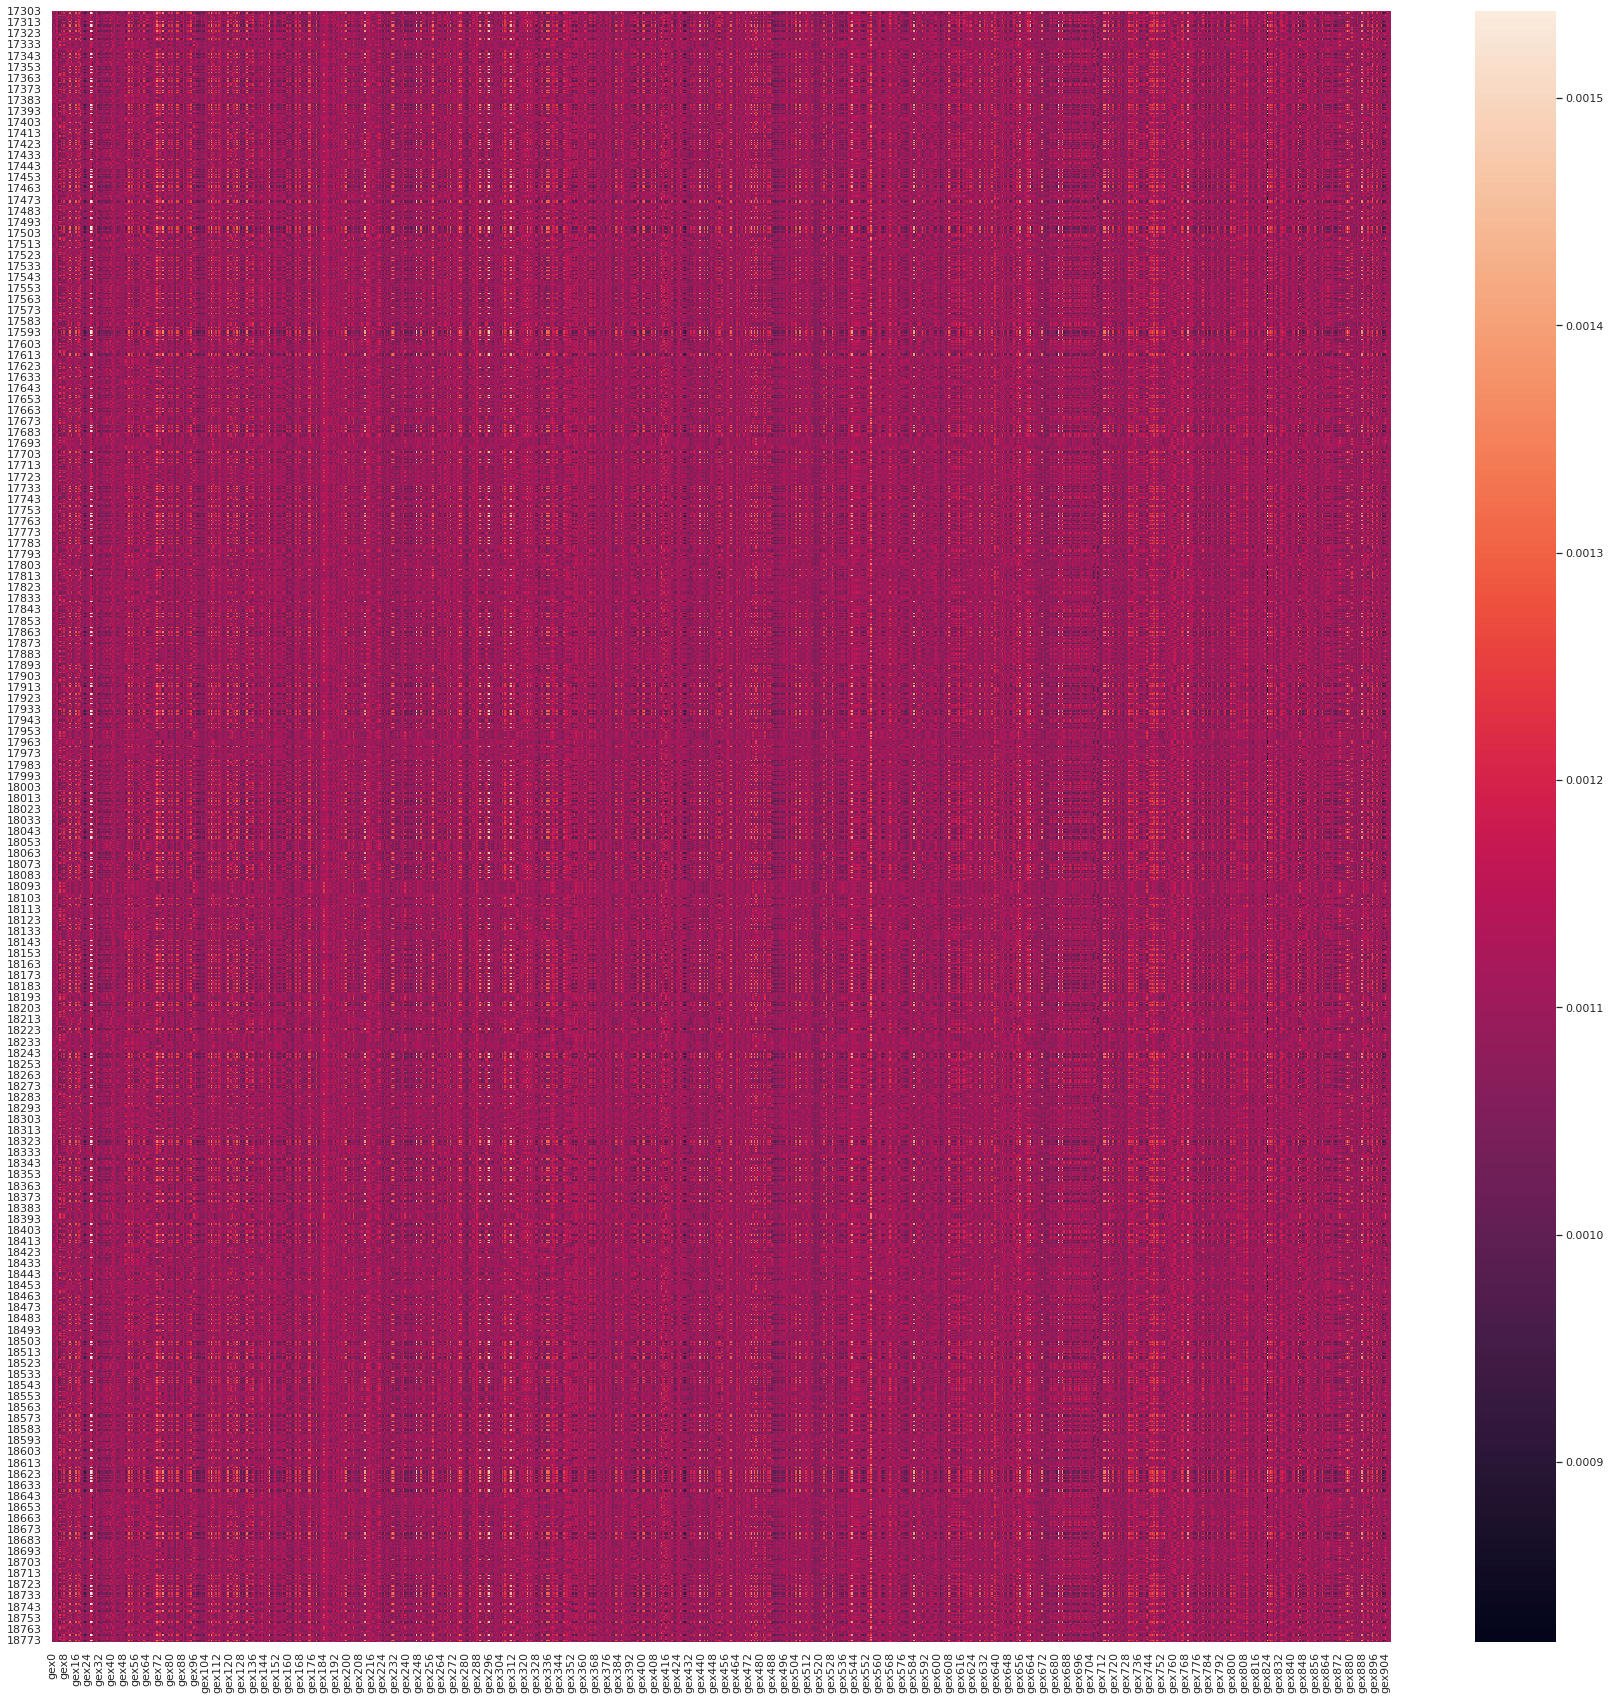

In [43]:
sns.heatmap(sel_gex)

/opt/conda/envs/graphnn/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


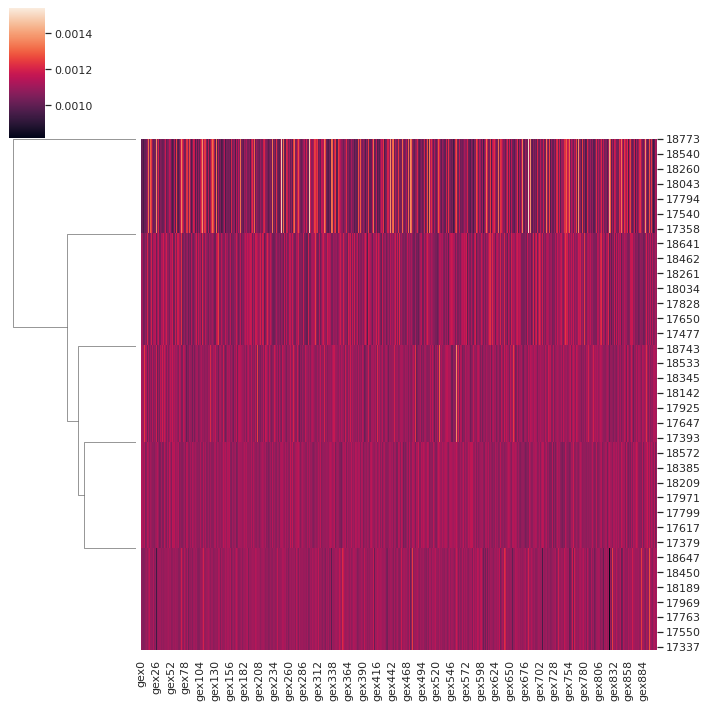

In [44]:
sns.clustermap(sel_gex, col_cluster=False)

In [45]:
exp = 1 / len(gex)
exp

0.0011013215859030838

In [46]:
df_mean = pd.DataFrame(sel_gex.mean()).T
df_mean.T.describe()#.loc['75%'].values[0]

,0
count,908.000000
mean,0.001101
std,0.000027
min,0.001036
25%,0.001082
50%,0.001099
75%,0.001116
max,0.001228


In [47]:
df_mean_thresh = df_mean.copy()
thresh = df_mean.T.describe().loc['75%'].values[0]
df_mean_thresh[df_mean_thresh < thresh] = 0
df_mean_thresh

,gex0,gex1,gex2,gex3,gex4,gex5,gex6,gex7,gex8,gex9,...,gex898,gex899,gex900,gex901,gex902,gex903,gex904,gex905,gex906,gex907
0,0.0,0.0,0.0,0.001127,0.0,0.0,0.0,0.0,0.001126,0.0,...,0.001119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

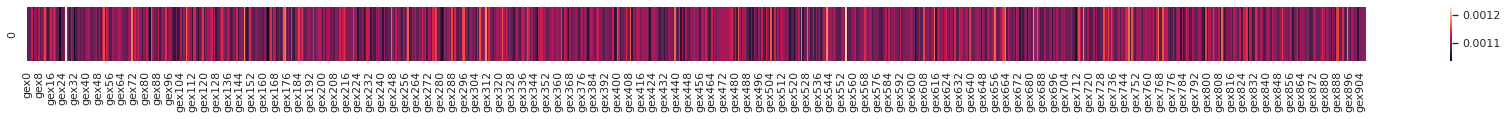

In [48]:
sns.set(rc={'figure.figsize':(30,1)})

sns.heatmap(df_mean)

In [49]:
top_attn_genes(sel_gex, 10)

NISCH      0.001228
IQGAP1     0.001214
DUSP14     0.001187
SLC11A2    0.001183
ANXA7      0.001181
ZNF586     0.001181
MELK       0.001179
PPP2R3C    0.001178
HMG20B     0.001176
NRAS       0.001176
dtype: float64

In [50]:
sel_gex.mean().sort_values(ascending=False).head(10).rename(index=dict_gene_gex)

NISCH      0.001228
IQGAP1     0.001214
DUSP14     0.001187
SLC11A2    0.001183
ANXA7      0.001181
ZNF586     0.001181
MELK       0.001179
PPP2R3C    0.001178
HMG20B     0.001176
NRAS       0.001176
dtype: float64